In [1]:
%load_ext autoreload
%autoreload true

In [2]:
import sys
sys.path.insert(0, '../..')

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

from utils import DataManager
from HeatPump import *

# Instantiation of the best model

In [3]:
from sklearn.decomposition import PCA

scaler = PCA(n_components=10, whiten=True)

In [4]:
from sklearn.linear_model import LogisticRegression

# Best model from hyper optimisation
model = LogisticRegression(C=1.4772074119404366, l1_ratio=0.5, max_iter=611, n_jobs=15,
                   random_state=1, tol=3.1663746054422205e-05)


# Loading train data and training model

In [5]:
from load_fault_dataset import HeatPumpFaultLoader

loader = HeatPumpFaultLoader(os.path.join(DATA_ROOT, 'HeatPump-20220908'))

train_faults = pd.read_csv(TRAIN_SPEC, index_col=0)
data_train, metadata_train = loader.load_fault_dataset_df(list(train_faults.index.values))
dm_train = DataManager()
dm_train.prepare_database(data_train, metadata_train, del_cols=HIDDEN_VARS+['anomaly'])

X_train, y_train = dm_train.split_X_Y_concat()

In [6]:
scaler.fit(X_train)

PCA(n_components=10, whiten=True)

In [7]:
model.fit(scaler.transform(X_train), y_train)

c:\Users\mv242848\Anaconda3\envs\ai_dhc_v2\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


LogisticRegression(C=1.4772074119404366, l1_ratio=0.5, max_iter=611, n_jobs=15,
                   random_state=1, tol=3.1663746054422205e-05)

# Load test data and computing predictions

In [8]:
test_faults = pd.read_csv(TEST_SPEC, index_col=0)
data_test , metadata_test = loader.load_fault_dataset_df(list(test_faults.index.values))
dm_test = DataManager()
dm_test.prepare_database(data_test, metadata_test, del_cols=HIDDEN_VARS+['anomaly'])

X_test, y_test = dm_test.split_X_Y_concat()

y_pred = model.predict(scaler.transform(X_test))

# Computing model scores

In [9]:
mcc = matthews_corrcoef(y_test,	y_pred)
print("MCC: %.3f" % mcc)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: %.3f" % acc)

MCC: 0.787
Accuracy: 0.911


# Plotting sample results

In [10]:
X_test_plot, y_test_plot = dm_test.split_X_Y()

for p in y_test_plot:
    p.index = pd.TimedeltaIndex(300 * p.index, unit='s')


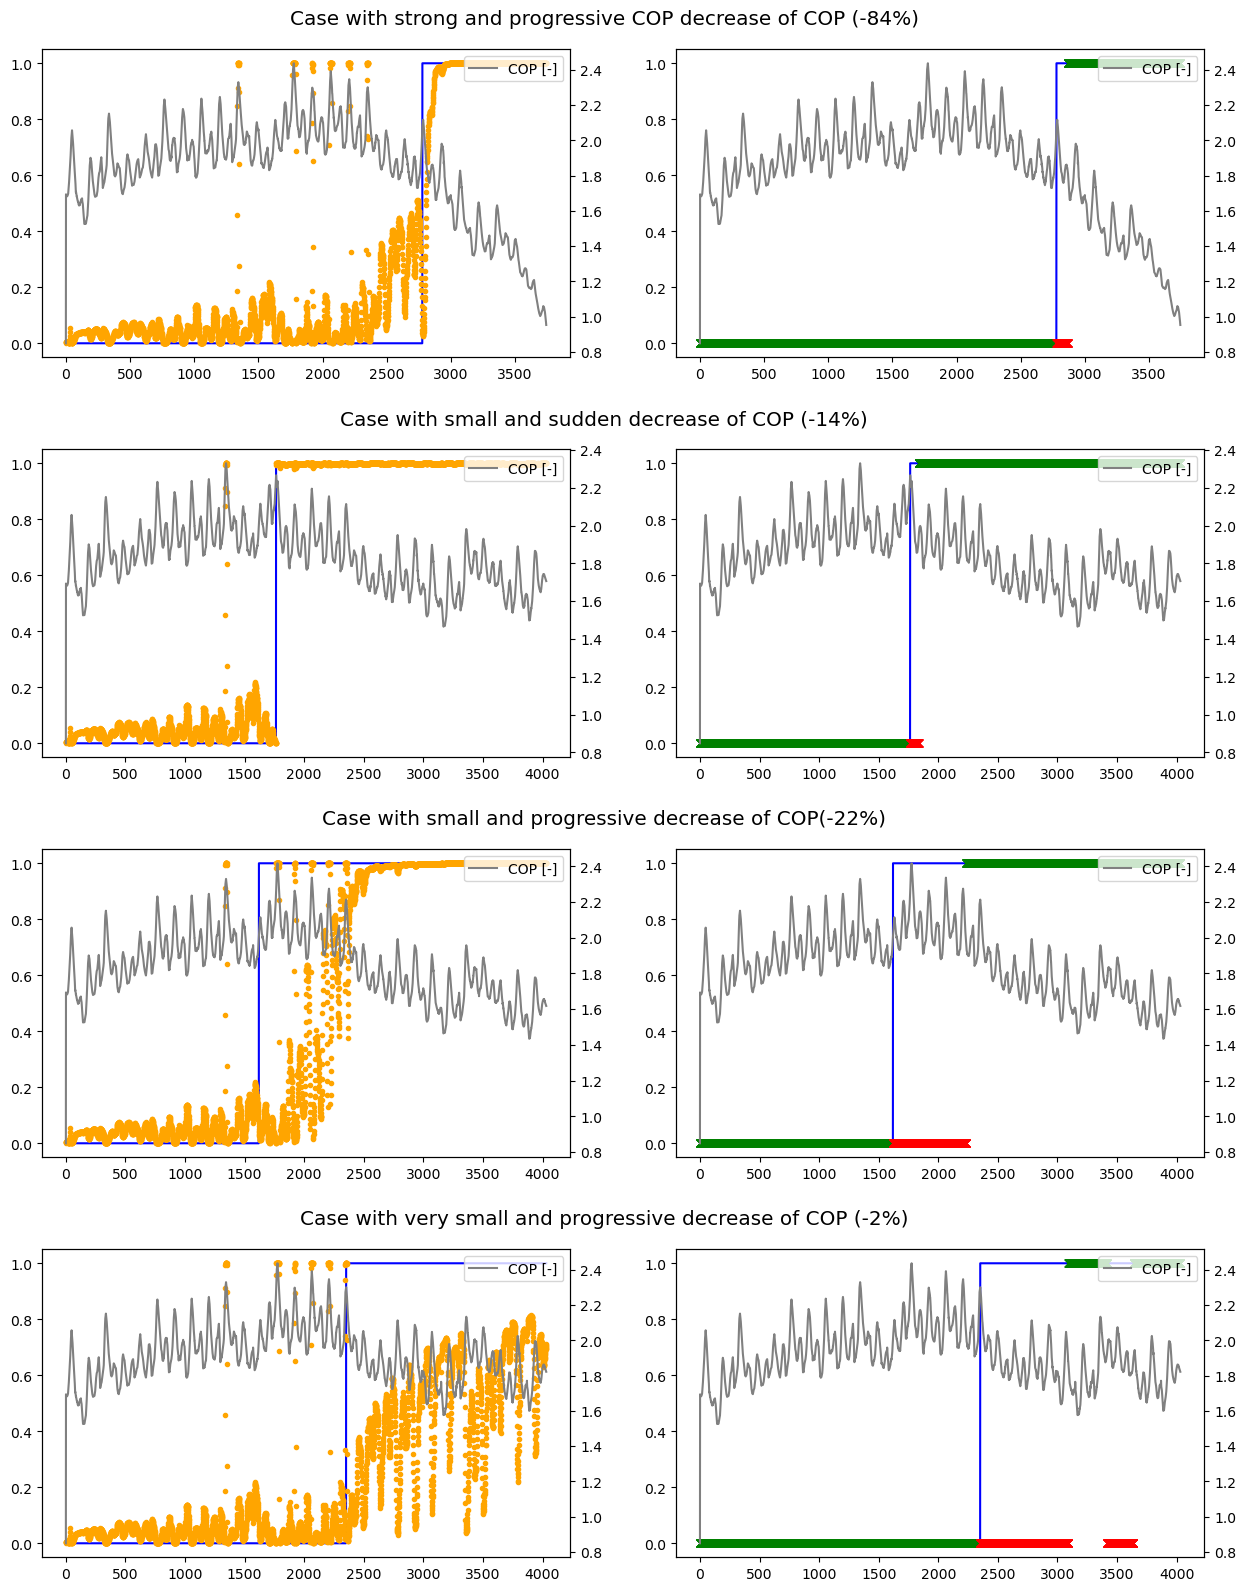

In [20]:
from Yacine.model_evaluation_plots import *

fault_var = 'COP'
fault_var_label = 'COP [-]'

test_ids = [9,4,3,2] #, range(10)
titles = [
    'Case with strong and progressive COP decrease of COP (-84%)',
    'Case with small and sudden decrease of COP (-14%)',
    'Case with small and progressive decrease of COP(-22%)',
    'Case with very small and progressive decrease of COP (-2%)',
]

nb_test = len(test_ids)
#fig, ax = plt.subplots(nb_test, 2, figsize=(25,6*nb_test))
fig = plt.figure(figsize=(15,4*nb_test))

subfigs = fig.subfigures(nrows=nb_test, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(titles[row], fontsize='x-large')
    ax = subfig.subplots(nrows=1, ncols=2)

    ii = test_ids[row]
    y_data = y_test_plot[ii].values.astype(np.float64)
    y_prob = model.predict_proba(scaler.transform(X_test_plot[ii]))[:,1]
    y_pred = alert_trigger(horizon=144, proba=y_prob, threshold=0.5)
    # y_pred = model.predict(scaler.transform(X_test_plot[ii]))
    fault_var_data = dm_test.del_cols_data[ii][fault_var].values.astype(np.float64)

    plot_proba(ax[0], y_data, y_prob, fault_var_label, fault_var_data)
    plot_true_false(ax[1], y_data, y_pred, fault_var_label, fault_var_data) 